In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import losses
import utils

In [2]:
import os
import itertools
import re
import numpy as np
import pandas as pd
# PyTorch
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_val_acc1(df):
    if 'val_or_test_acc' in df.columns:
        return df.val_or_test_acc.values[-1] if df.val_or_test_acc.values[-1] < 1 else df.val_or_test_acc.values[-1]/100
    elif 'val_or_test_acc1' in df.columns:
        return df.val_or_test_acc1.values[-1] if df.val_or_test_acc1.values[-1] < 1 else df.val_or_test_acc1.values[-1]/100

In [4]:
def get_best_hyperparams(
    bb_weight_decays, 
    clf_weight_decays, 
    experiments_path, # Gets best hyperparameters from experiments_path
    lr_0s, 
    ns, 
    prior_type, # Gets best hyperparameters for a single prior_type
    random_states, 
    weight_decays
):
    hyperparam_names = ['bb_weight_decay', 'clf_weight_decay', 'lr_0', 'n', 'random_state', 'weight_decay']
    columns = ['model_name', 'n', 'prior_type', 'random_state', 'val_acc1', 'val_nll']
    df = pd.DataFrame(columns=columns)
    
    for hyperparams in itertools.product(bb_weight_decays, clf_weight_decays, lr_0s, ns, random_states, weight_decays):
        model_name = f'{prior_type}_' + '_'.join(f'{hyperparam_name}={hyperparam}' for hyperparam_name, hyperparam in zip(hyperparam_names, hyperparams) if hyperparam is not None)
        bb_weight_decay, clf_weight_decay, lr_0, n, random_state, weight_decay = hyperparams
        if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
            print(model_name)
            pass
        else:
            temp_df = get_df(f'{experiments_path}/{model_name}.csv')
            val_acc1 = get_val_acc1(temp_df)
            val_nll = get_val_nll(temp_df)
            df.loc[df.shape[0]] = [model_name, n, prior_type, random_state, val_acc1, val_nll]
    
    df['rank_value'] = df.groupby(['n', 'random_state'])['val_nll'].rank()
    df = df[(df['rank_value'] <= 3)|(df['rank_value'] == df['rank_value'].max()/4)|(df['rank_value'] == df['rank_value'].max()/2)].reset_index(drop=True)

    return df

def get_results(
    df,
    experiments_path
):
    columns = ['model_name', 'n', 'prior_type', 'random_state', 'rank_value', 'test_acc1', 'test_nll']
    results_df = pd.DataFrame(columns=columns)
    
    for row_index, row in df.iterrows():
        model_name = row.model_name
        prior_type, n, random_state = row.prior_type, row.n, row.random_state
        if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
            #print(model_name)
            pass
        else:
            temp_df = get_df(f'{experiments_path}/{model_name}.csv')
            test_acc1 = get_val_acc1(temp_df)
            test_nll = get_val_nll(temp_df)
            results_df.loc[results_df.shape[0]] = [model_name, n, prior_type, random_state, row.rank_value, test_acc1, test_nll]
                
    return results_df

In [5]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [1000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'nonlearned'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_C'
weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]

std_prior = get_best_hyperparams([None], [None], experiments_path, lr_0s, ns, prior_type, random_states, weight_decays)
std_prior

,model_name,n,prior_type,random_state,val_acc1,val_nll,rank_value
0,nonlearned_lr_0=0.01_n=1000_random_state=1001_...,1000,nonlearned,1001,0.770,0.697320,2.0
1,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,0.820,0.803543,1.0
2,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,0.805,0.916837,12.0
3,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,0.865,0.434508,1.0
4,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,0.865,0.472507,2.0
5,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,0.875,0.519339,3.0
6,nonlearned_lr_0=0.001_n=1000_random_state=1001...,1000,nonlearned,1001,0.765,0.841034,12.0
7,nonlearned_lr_0=0.001_n=1000_random_state=3001...,1000,nonlearned,3001,0.840,0.621079,12.0
8,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,0.740,0.725388,3.0
9,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,0.755,0.670592,1.0


In [6]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
wandb_project = 'retrained_C'

pattern = re.compile(r'(\w+)_lr_0=([\d.]+)_n=(\d+)_random_state=(\d+)_weight_decay=([\d.]+(?:e[-+]?\d+)?)')
for row_index, row in std_prior.iterrows():
    model_name = row.model_name
    match = pattern.match(model_name)
    prior_type, lr_0, n, random_state, weight_decay = match.groups()
    if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
        print(f'    "python ../src/main_CIFAR-10.py --bb_weight_decay={weight_decay} --clf_weight_decay={weight_decay} --dataset_path=\'{dataset_path}\' --experiments_path=\'{experiments_path}\' --lr_0={lr_0} --n={n} --model_name=\'{model_name}\' --prior_path=\'{prior_path}\' --prior_type=\'{prior_type}\' --random_state={random_state} --save --wandb --wandb_project=\'{wandb_project}\'"')

In [7]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [1000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'adapted'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_C'
weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]

learned_prior_iso = get_best_hyperparams([None], [None], experiments_path, lr_0s, ns, prior_type, random_states, weight_decays)
learned_prior_iso

,model_name,n,prior_type,random_state,val_acc1,val_nll,rank_value
0,adapted_lr_0=0.1_n=1000_random_state=1001_weig...,1000,adapted,1001,0.835,0.523390,1.0
1,adapted_lr_0=0.1_n=1000_random_state=2001_weig...,1000,adapted,2001,0.815,0.667335,1.0
2,adapted_lr_0=0.01_n=1000_random_state=1001_wei...,1000,adapted,1001,0.850,0.579450,2.0
3,adapted_lr_0=0.01_n=1000_random_state=1001_wei...,1000,adapted,1001,0.825,0.605200,3.0
4,adapted_lr_0=0.01_n=1000_random_state=2001_wei...,1000,adapted,2001,0.805,0.765132,2.0
5,adapted_lr_0=0.01_n=1000_random_state=2001_wei...,1000,adapted,2001,0.835,0.877337,12.0
6,adapted_lr_0=0.01_n=1000_random_state=2001_wei...,1000,adapted,2001,0.850,0.766194,3.0
7,adapted_lr_0=0.01_n=1000_random_state=3001_wei...,1000,adapted,3001,0.855,0.464546,6.0
8,adapted_lr_0=0.01_n=1000_random_state=3001_wei...,1000,adapted,3001,0.885,0.411353,2.0
9,adapted_lr_0=0.01_n=1000_random_state=3001_wei...,1000,adapted,3001,0.885,0.441444,3.0


In [8]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
wandb_project = 'retrained_C'

pattern = re.compile(r'(\w+)_lr_0=([\d.]+)_n=(\d+)_random_state=(\d+)_weight_decay=([\d.]+(?:e[-+]?\d+)?)')
for row_index, row in learned_prior_iso.iterrows():
    model_name = row.model_name
    match = pattern.match(model_name)
    prior_type, lr_0, n, random_state, weight_decay = match.groups()
    if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
        print(f'    "python ../src/main_CIFAR-10.py --bb_weight_decay={weight_decay} --clf_weight_decay={weight_decay} --dataset_path=\'{dataset_path}\' --experiments_path=\'{experiments_path}\' --lr_0={lr_0} --n={n} --model_name=\'{model_name}\' --prior_path=\'{prior_path}\' --prior_type=\'{prior_type}\' --random_state={random_state} --save --wandb --wandb_project=\'{wandb_project}\'"')

In [9]:
bb_weight_decays = np.logspace(0, 9, num=10)
clf_weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [1000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'LearnedPriorLR'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_C'

learned_prior_lr = get_best_hyperparams(bb_weight_decays, clf_weight_decays, experiments_path, lr_0s, ns, prior_type, random_states, [None])
learned_prior_lr

,model_name,n,prior_type,random_state,val_acc1,val_nll,rank_value
0,LearnedPriorLR_bb_weight_decay=10.0_clf_weight...,1000,LearnedPriorLR,2001,0.810,0.624078,2.0
1,LearnedPriorLR_bb_weight_decay=10.0_clf_weight...,1000,LearnedPriorLR,3001,0.895,0.299455,1.0
2,LearnedPriorLR_bb_weight_decay=10.0_clf_weight...,1000,LearnedPriorLR,1001,0.860,0.499381,3.0
3,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,1001,0.860,0.455539,2.0
4,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,2001,0.830,0.609634,1.0
5,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,3001,0.925,0.300820,2.0
6,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,3001,0.900,0.333704,3.0
7,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,2001,0.810,0.859697,120.0
8,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,1001,0.875,0.436516,1.0
9,LearnedPriorLR_bb_weight_decay=1000.0_clf_weig...,1000,LearnedPriorLR,2001,0.725,0.822845,60.0


In [10]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
wandb_project = 'retrained_C'

pattern = re.compile(r'(\w+)_bb_weight_decay=([\d.]+)_clf_weight_decay=([\d.]+(?:e[-+]?\d+)?)_lr_0=([\d.]+)_n=(\d+)_random_state=(\d+)')
for row_index, row in learned_prior_lr.iterrows():
    model_name = row.model_name
    match = pattern.match(model_name)
    prior_type, bb_weight_decay, clf_weight_decay, lr_0, n, random_state = match.groups()
    if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
        print(f'    "python ../src/main_CIFAR-10.py --bb_weight_decay={bb_weight_decay} --clf_weight_decay={clf_weight_decay} --dataset_path=\'{dataset_path}\' --experiments_path=\'{experiments_path}\' --lr_0={lr_0} --n={n} --model_name=\'{model_name}\' --prior_path=\'{prior_path}\' --prior_type=\'{prior_type}\' --random_state={random_state} --save --wandb --wandb_project=\'{wandb_project}\'"')

In [11]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
std_prior_results = get_results(std_prior, experiments_path)
learned_prior_iso_results = get_results(learned_prior_iso, experiments_path)
learned_prior_lr_results = get_results(learned_prior_lr, experiments_path)
results = pd.concat([std_prior_results, learned_prior_iso_results, learned_prior_lr_results])
results

,model_name,n,prior_type,random_state,rank_value,test_acc1,test_nll
0,nonlearned_lr_0=0.01_n=1000_random_state=1001_...,1000,nonlearned,1001,2.0,0.8109,0.756265
1,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,1.0,0.8181,0.790316
2,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,12.0,0.8105,0.811299
3,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,1.0,0.8275,0.655546
4,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,2.0,0.8258,0.734187
5,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,3.0,0.8254,0.768437
6,nonlearned_lr_0=0.001_n=1000_random_state=1001...,1000,nonlearned,1001,12.0,0.7858,0.848463
7,nonlearned_lr_0=0.001_n=1000_random_state=3001...,1000,nonlearned,3001,12.0,0.8036,0.785231
8,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,3.0,0.7755,0.698573
9,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,1.0,0.7818,0.689700


In [12]:
results.rank_value[results.rank_value==6] = 4
results.rank_value[results.rank_value==60] = 4
results.rank_value[results.rank_value==12] = 5
results.rank_value[results.rank_value==120] = 5

/tmp/ipykernel_3529636/2113699187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.rank_value[results.rank_value==6] = 4
/tmp/ipykernel_3529636/2113699187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.rank_value[results.rank_value==60] = 4
/tmp/ipykernel_3529636/2113699187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.rank_value[results.rank_value==12] = 5
/tmp/ipykernel_3529636/2113699187.py:4: S

In [13]:
grouped_results = results.groupby(['n', 'prior_type', 'rank_value']).agg(lambda x: tuple(x))
columns = ['test_acc1', 'test_nll']
for column in columns:
    grouped_results[f'{column}_mean'] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results[f'{column}_std'] = grouped_results[column].apply(lambda item: np.std(item))
    grouped_results[f'{column}_min'] = grouped_results[column].apply(lambda item: np.min(item))
    grouped_results[f'{column}_max'] = grouped_results[column].apply(lambda item: np.max(item))
grouped_results = grouped_results.reset_index()
grouped_results

,n,prior_type,rank_value,model_name,random_state,test_acc1,test_nll,test_acc1_mean,test_acc1_std,test_acc1_min,test_acc1_max,test_nll_mean,test_nll_std,test_nll_min,test_nll_max
0,1000,LearnedPriorLR,1.0,(LearnedPriorLR_bb_weight_decay=10.0_clf_weigh...,"(3001, 2001, 1001)","(0.8346999999999999, 0.8326000000000002, 0.838...","(0.5788421309471129, 0.5649791242122649, 0.582...",0.835300,0.002486,0.8326,0.8386,0.575300,0.007416,0.564979,0.582078
1,1000,LearnedPriorLR,2.0,(LearnedPriorLR_bb_weight_decay=10.0_clf_weigh...,"(2001, 1001, 3001)","(0.8254000000000002, 0.8355, 0.8387999999999998)","(0.6043808805465699, 0.5477198763847351, 0.564...",0.833233,0.005700,0.8254,0.8388,0.572061,0.023810,0.547720,0.604381
2,1000,LearnedPriorLR,3.0,(LearnedPriorLR_bb_weight_decay=10.0_clf_weigh...,"(1001, 3001, 2001)","(0.8395, 0.8305000000000002, 0.8285000000000003)","(0.5755792673110963, 0.6138064291000366, 0.638...",0.832833,0.004784,0.8285,0.8395,0.609179,0.025753,0.575579,0.638150
3,1000,LearnedPriorLR,4.0,(LearnedPriorLR_bb_weight_decay=1000.0_clf_wei...,"(2001, 3001, 1001)","(0.7779000997543335, 0.8329999446868896, 0.774...","(0.6795024831771853, 0.6319433521270758, 0.700...",0.795200,0.026760,0.7747,0.8330,0.670499,0.028525,0.631943,0.700052
4,1000,LearnedPriorLR,5.0,(LearnedPriorLR_bb_weight_decay=100.0_clf_weig...,"(2001, 3001, 1001)","(0.8246999979019165, 0.7885000109672546, 0.790...","(0.6419614248275759, 0.6727255256652831, 0.832...",0.801367,0.016528,0.7885,0.8247,0.715680,0.083451,0.641961,0.832353
5,1000,adapted,1.0,(adapted_lr_0=0.1_n=1000_random_state=1001_wei...,"(1001, 2001, 3001)","(0.8163000345230103, 0.820099949836731, 0.8209...","(0.6228910679817198, 0.6203525841712954, 0.782...",0.819133,0.002037,0.8163,0.8210,0.675372,0.076022,0.620353,0.782873
6,1000,adapted,2.0,(adapted_lr_0=0.01_n=1000_random_state=1001_we...,"(1001, 2001, 3001)","(0.8200000000000003, 0.8301999999999998, 0.838...","(0.6559176585674283, 0.6392433458805082, 0.607...",0.829700,0.007724,0.8200,0.8389,0.634243,0.020053,0.607567,0.655918
7,1000,adapted,3.0,(adapted_lr_0=0.01_n=1000_random_state=1001_we...,"(1001, 2001, 3001)","(0.8271000000000001, 0.8177000000000002, 0.830...","(0.6510786563873295, 0.8159913855552676, 0.711...",0.825067,0.005380,0.8177,0.8304,0.726242,0.068111,0.651079,0.815991
8,1000,adapted,4.0,(adapted_lr_0=0.01_n=1000_random_state=3001_we...,"(3001, 1001, 2001)","(0.8282999992370605, 0.7748998999595642, 0.777...","(0.6320229287147522, 0.7032971774101259, 0.679...",0.793633,0.024540,0.7749,0.8283,0.671499,0.029600,0.632023,0.703297
9,1000,adapted,5.0,(adapted_lr_0=0.01_n=1000_random_state=2001_we...,"(2001, 1001, 3001)","(0.8174000382423401, 0.789900004863739, 0.7918...","(0.7535515274047848, 0.8367634561538695, 0.666...",0.799700,0.012540,0.7899,0.8174,0.752328,0.069446,0.666669,0.836763


In [14]:
grouped_results[['n', 'prior_type', 'rank_value', 'test_acc1_mean', 'test_acc1_min', 'test_acc1_max']]

,n,prior_type,rank_value,test_acc1_mean,test_acc1_min,test_acc1_max
0,1000,LearnedPriorLR,1.0,0.835300,0.8326,0.8386
1,1000,LearnedPriorLR,2.0,0.833233,0.8254,0.8388
2,1000,LearnedPriorLR,3.0,0.832833,0.8285,0.8395
3,1000,LearnedPriorLR,4.0,0.795200,0.7747,0.8330
4,1000,LearnedPriorLR,5.0,0.801367,0.7885,0.8247
5,1000,adapted,1.0,0.819133,0.8163,0.8210
6,1000,adapted,2.0,0.829700,0.8200,0.8389
7,1000,adapted,3.0,0.825067,0.8177,0.8304
8,1000,adapted,4.0,0.793633,0.7749,0.8283
9,1000,adapted,5.0,0.799700,0.7899,0.8174


In [15]:
grouped_results[['n', 'prior_type', 'rank_value', 'test_nll_mean', 'test_nll_min', 'test_nll_max']]

,n,prior_type,rank_value,test_nll_mean,test_nll_min,test_nll_max
0,1000,LearnedPriorLR,1.0,0.575300,0.564979,0.582078
1,1000,LearnedPriorLR,2.0,0.572061,0.547720,0.604381
2,1000,LearnedPriorLR,3.0,0.609179,0.575579,0.638150
3,1000,LearnedPriorLR,4.0,0.670499,0.631943,0.700052
4,1000,LearnedPriorLR,5.0,0.715680,0.641961,0.832353
5,1000,adapted,1.0,0.675372,0.620353,0.782873
6,1000,adapted,2.0,0.634243,0.607567,0.655918
7,1000,adapted,3.0,0.726242,0.651079,0.815991
8,1000,adapted,4.0,0.671499,0.632023,0.703297
9,1000,adapted,5.0,0.752328,0.666669,0.836763


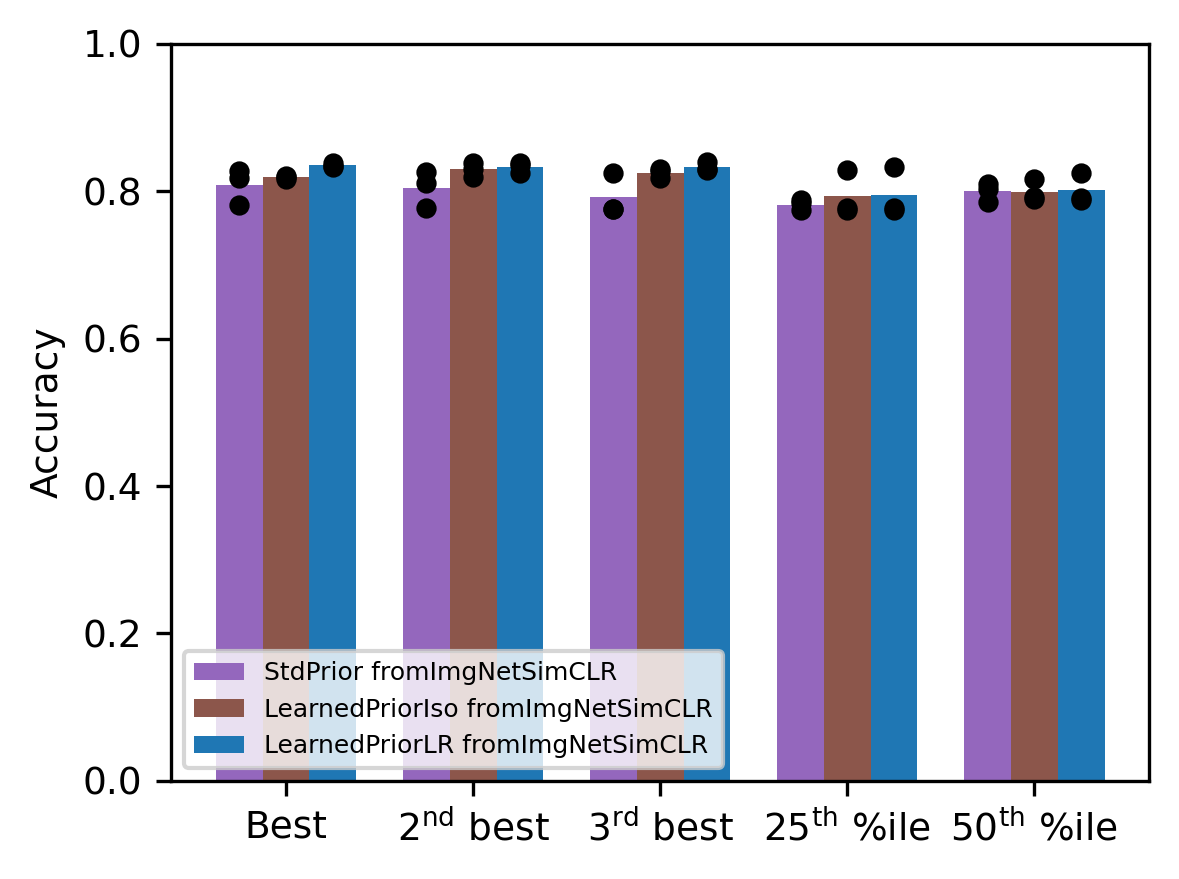

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
ax.bar(grouped_results[grouped_results.prior_type=='nonlearned'].rank_value-0.25, grouped_results[grouped_results.prior_type=='nonlearned'].test_acc1_mean, color='#9467bd', label='StdPrior fromImgNetSimCLR', linewidth=0, width=0.25)
ax.bar(grouped_results[grouped_results.prior_type=='adapted'].rank_value, grouped_results[grouped_results.prior_type=='adapted'].test_acc1_mean, color='#8c564b', label='LearnedPriorIso fromImgNetSimCLR', linewidth=0, width=0.25)
ax.bar(grouped_results[grouped_results.prior_type=='LearnedPriorLR'].rank_value+0.25, grouped_results[grouped_results.prior_type=='LearnedPriorLR'].test_acc1_mean, color='#1f77b4', label='LearnedPriorLR fromImgNetSimCLR', linewidth=0, width=0.25)
ax.scatter(results[results.prior_type=='nonlearned'].rank_value-0.25, results[results.prior_type=='nonlearned'].test_acc1.values, color='black', s=15)
ax.scatter(results[results.prior_type=='adapted'].rank_value, results[results.prior_type=='adapted'].test_acc1.values, color='black', s=15)
ax.scatter(results[results.prior_type=='LearnedPriorLR'].rank_value+0.25, results[results.prior_type=='LearnedPriorLR'].test_acc1.values, color='black', s=15)
ax.set_ylim([0, 1.0])
ax.set_xticks(list(range(1,6)))
ax.set_xticklabels([
    'Best', 
    r'$2^{\mathrm{nd}}\ \mathrm{best}$', 
    r'$3^{\mathrm{rd}}\ \mathrm{best}$', 
    r'$25^{\mathrm{th}}\ \mathrm{\%ile}$', 
    r'$50^{\mathrm{th}}\ \mathrm{\%ile}$', 
])
ax.legend(loc='lower left', fontsize=6)
ax.set_ylabel('Accuracy')
fig.tight_layout()
plt.savefig('hyperparameter_sensitivity.pdf', bbox_inches='tight')
plt.show()